# CVE Data Analysis Tools

This notebook contains tools for analysizing the tools CNAs use to publish CVEs.

In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import re

## Load and Parse CVE Data

In [3]:
# Construct the base path relative to the current working directory
base_path = os.path.join(os.getcwd(), '..', '..', 'Data', 'CVE', 'cves')

data = []

# Traverse the directory tree
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith('.json'):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                cve_data = json.load(f)
                if isinstance(cve_data, dict):
                    cveId = cve_data.get('cveMetadata', {}).get('cveId')
                    shortName = cve_data.get('cveMetadata', {}).get('assignerShortName')
                    datePublished = cve_data.get('cveMetadata', {}).get('datePublished')
                    containers = cve_data.get('containers', {})
                    if isinstance(containers, dict):
                        cna = containers.get('cna', {})
                        if isinstance(cna, dict):
                            x_generator = cna.get('x_generator', {})
                            if isinstance(x_generator, dict):
                                x_generator = x_generator.get('engine')
                            else:
                                x_generator = None
                        else:
                            x_generator = None
                    else:
                        x_generator = None
                    data.append({
                        'cveId': cveId,
                        'shortName': shortName,
                        'x_generator': x_generator,
                        'datePublished': datePublished
                    })

cve_df = pd.DataFrame(data)

cve_df.rename(columns={
    'cveId': 'CVE',
    'shortName': 'CNA',
    'x_generator': 'Tool',
    'datePublished': 'Date'
}, inplace=True)


# Drop rows with NaT values in the Date column
cve_df = cve_df.dropna(subset=['Date'])


## Extract and Normalize Data

In [4]:

# Copy cve_df to tool_df   
tool_df = cve_df.copy()

# Extract the date part (YYYY-MM-DD) using a regular expression
tool_df['Date'] = tool_df['Date'].apply(lambda x: re.search(r'\d{4}-\d{2}-\d{2}', x).group(0) if pd.notna(x) else None)

# Convert the extracted date to datetime format
tool_df['Date'] = pd.to_datetime(tool_df['Date'], errors='coerce')

# Extract the year from the Date column
tool_df['Year'] = tool_df['Date'].dt.year

# Function to normalize tool names
def normalize_tool_name(tool_name):
    if pd.isna(tool_name):
        return tool_name
    tool_name = re.sub(r'vulnogram.*', 'Vulnogram', tool_name, flags=re.IGNORECASE)
    tool_name = re.sub(r'vince.*', 'VINCE', tool_name, flags=re.IGNORECASE)
    tool_name = re.sub(r'cveclient/.*', 'cveClient', tool_name, flags=re.IGNORECASE)
    tool_name = re.sub(r'bippy-.*', 'Bippy', tool_name, flags=re.IGNORECASE)
    return tool_name

# Apply the normalization function to the Tools column
tool_df['Tool'] = tool_df['Tool'].apply(normalize_tool_name)

## Most Popular Tool (Excluding None)

In [5]:
# Get the value counts of the Tool column, excluding NA values
tool_counts = tool_df['Tool'].value_counts(dropna=True)

# Convert the value counts into a DataFrame
tool_counts_df = tool_counts.reset_index()
tool_counts_df.columns = ['Tool', 'Count']

# Calculate the percentage and round to two decimal points
tool_counts_df['Percentage'] = (tool_counts_df['Count'] / tool_counts_df['Count'].sum() * 100).round(2)

# Export the DataFrame as a CSV file
tool_counts_df.to_csv('tool_counts.csv', index=False)

# Display the DataFrame
tool_counts_df.head(10)

,Tool,Count,Percentage
0,Vulnogram,27729,77.19
1,Bippy,5458,15.19
2,WPScan CVE Generator,2042,5.68
3,cveClient,245,0.68
4,VINCE,156,0.43
5,enrichogram 0.0.1,135,0.38
6,F5 SIRTBot v1.0,104,0.29
7,Robot Vulnerability Database (RVD),28,0.08
8,SecretariatVulnogram,14,0.04
9,advisoriator,8,0.02


## Most Popular Tool (Including None)

In [6]:
# Get the value counts of the Tool column, Including NA values
tool_counts = tool_df['Tool'].value_counts(dropna=False)

# Convert the value counts into a DataFrame
tool_counts_df = tool_counts.reset_index()
tool_counts_df.columns = ['Tool', 'Count']

# Calculate the percentage and round to two decimal points
tool_counts_df['Percentage'] = (tool_counts_df['Count'] / tool_counts_df['Count'].sum() * 100).round(2)

# Export the DataFrame as a CSV file
tool_counts_df.to_csv('tool_counts_with_none.csv', index=False)

# Display the DataFrame
tool_counts_df.head(10)

,Tool,Count,Percentage
0,None,245079,87.22
1,Vulnogram,27729,9.87
2,Bippy,5458,1.94
3,WPScan CVE Generator,2042,0.73
4,cveClient,245,0.09
5,VINCE,156,0.06
6,enrichogram 0.0.1,135,0.05
7,F5 SIRTBot v1.0,104,0.04
8,Robot Vulnerability Database (RVD),28,0.01
9,SecretariatVulnogram,14,0.00


## Graph The Top Tools

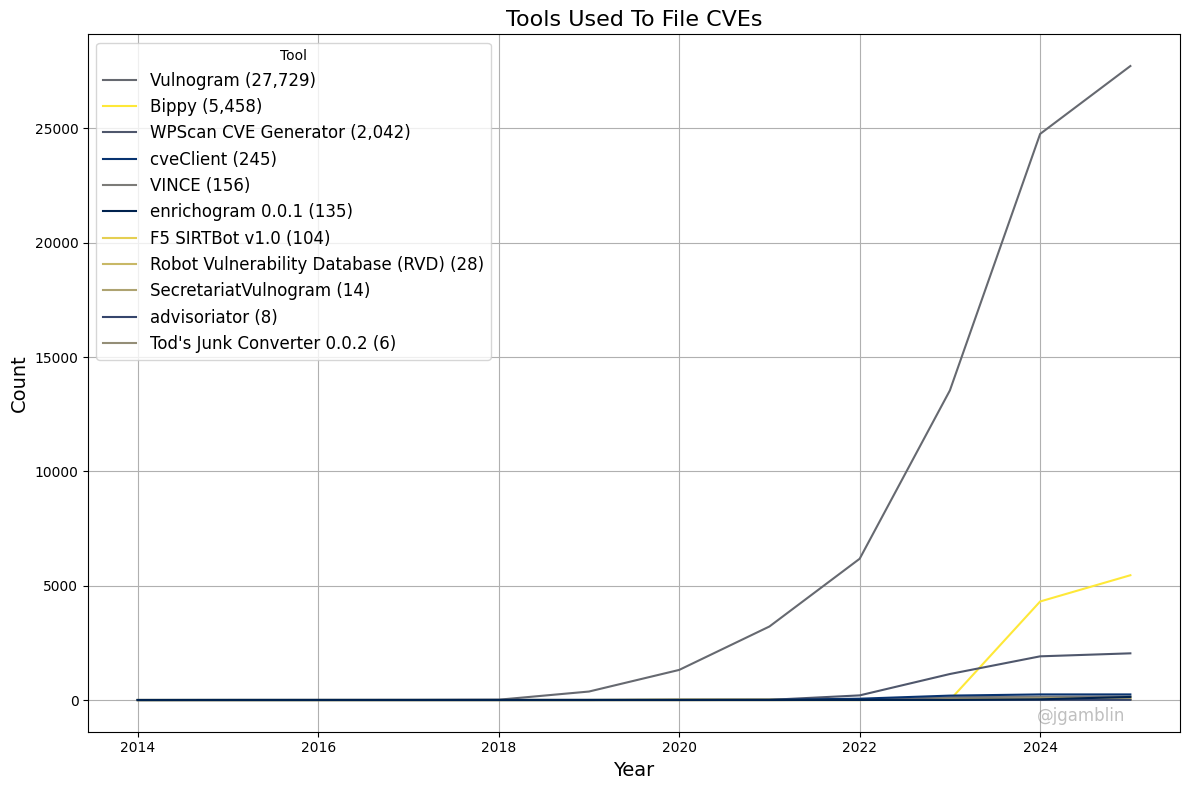

In [7]:

# Group by Year and Tool, and count the occurrences
grouped_df = tool_df.groupby(['Year', 'Tool']).size().reset_index(name='Count')

# Pivot the DataFrame to have tools as columns and years as rows
pivot_df = grouped_df.pivot(index='Year', columns='Tool', values='Count').fillna(0)

# Calculate the cumulative sum for each tool
cumulative_df = pivot_df.cumsum()

# Plot the cumulative counts
fig, ax = plt.subplots(figsize=(12, 8))
cumulative_df.plot(kind='line', colormap='cividis_r', ax=ax)

# Add title and labels
plt.title('Tools Used To File CVEs', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Sort the legend by the final cumulative count
handles, labels = ax.get_legend_handles_labels()
cumulative_counts = cumulative_df.iloc[-1]
sorted_legend = sorted(zip(handles, labels, cumulative_counts), key=lambda x: x[2], reverse=True)
sorted_handles, sorted_labels, sorted_counts = zip(*sorted_legend)

# Update the legend with counts formatted as whole numbers with commas
sorted_labels_with_counts = [f"{label} ({int(count):,})" for label, count in zip(sorted_labels, sorted_counts)]
ax.legend(sorted_handles, sorted_labels_with_counts, title='Tool', fontsize=12)

# Add watermark
plt.text(0.95, 0.01, '@jgamblin', verticalalignment='bottom', horizontalalignment='right',
         transform=ax.transAxes, color='grey', fontsize=12, alpha=0.5)

# Improve layout
plt.tight_layout()

# Save the plot as a high-quality PNG file
plt.savefig('cumulative_counts_by_tool.png', dpi=300)

# Show the plot
plt.show()

## Which CNA Uses Which Tools?

In [8]:
# Filter out rows where the Tool column is None
filtered_tool_df = tool_df[tool_df['Tool'].notna()]

# Create a DataFrame showing which CNA uses which Tool and the count of CVEs they filed with that tool, excluding None values
cna_tool_count = filtered_tool_df.groupby(['CNA', 'Tool']).size().reset_index(name='Count')

# Sort the DataFrame by Count in descending order
cna_tool_count = cna_tool_count.sort_values(by='CNA', ascending=True)

# Export the DataFrame as a CSV file
cna_tool_count.to_csv('cna_tool_count.csv', index=False)

# Display the DataFrame
cna_tool_count.head(10)


,CNA,Tool,Count
0,1E,Vulnogram,7
1,3DS,Vulnogram,39
2,42Gears,Vulnogram,3
3,9front,Vulnogram,1
4,@huntr_ai,Vulnogram,18
5,@huntrdev,Vulnogram,79
6,ABB,Vulnogram,177
7,AHA,Vulnogram,12
8,AMD,Vulnogram,277
9,AMI,Vulnogram,39
